# Expectation-maximization algorithm

In this assignment, we will derive and implement formulas for Gaussian Mixture Model — one of the most commonly used methods for performing soft clustering of the data. 

In [1]:
import numpy as np
import scipy
from numpy.linalg import slogdet, det, solve
from scipy.special import softmax
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
%matplotlib inline

## Implementing EM for GMM

For debugging, we will use samples from a Gaussian mixture model with unknown mean, variance, and priors. We also added initial values of parameters for grading purposes.

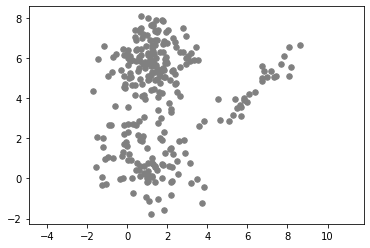

In [2]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

### Reminder

Remember, that EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned, i.e. $t_i$  is the cluster index for object $x_i$.

The joint distribution can be written as follows: $\mathbb{E}_{q(T)}\log p(T, X \mid \theta) =  \sum\limits_{i=1}^N \mathbb{E}_{q(T)}\log p(t_i, x_i \mid \theta) = \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \log \left (\pi_c \, f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)\right)$,
where $f_{\!\mathcal{N}}(x \mid \mu_c, \Sigma_c) = \frac{1}{\sqrt{(2\pi)^d|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})
\right)$ is the probability density function (pdf) of the normal distribution $\mathcal{N}(x_i \mid \mu_c, \Sigma_c)$.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q_i(t_i) = p(t_i \mid x_i, \theta)$. We assume that $t_i$ equals to the cluster index of the true component of the $x_i$ object. To do so we need to compute $\gamma_{ic} = p(t_i = c \mid x_i, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


<b>Important trick 1:</b> It is important to avoid numerical errors. At some point you will have to compute the formula of the following form: $\frac{e^{y_i}}{\sum_j e^{y_j}}$, which is called _softmax_. When you compute exponents of large numbers, some numbers may become infinity. You can avoid this by dividing numerator and denominator by $e^{\max(y)}$: $\frac{e^{y_i-\max(y)}}{\sum_j e^{y_j - \max(y)}}$. After this transformation maximum value in the denominator will be equal to one. All other terms will contribute smaller values. So, to compute desired formula you first subtract maximum value from each component in vector $\mathbf{y}$ and then compute everything else as before.

<b>Important trick 2:</b> You will probably need to compute formula of the form $A^{-1}x$ at some point. You would normally inverse $A$ and then multiply it by $x$. A bit faster and more numerically accurate way to do this is to directly solve equation $Ay = x$ by using a special function. Its solution is $y=A^{-1}x$, but the equation $Ay = x$ can be solved by methods which do not explicitely invert the matrix. You can use ```np.linalg.solve``` for this.

<b>Other usefull functions: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet```</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det```</a>

<b>Task 1:</b> Implement E-step for GMM using template below.

In [3]:
def normal_dist_pdf(X, mu, sigma):
    N = X.shape[0]  # number of objects
    d = X.shape[1]  # dimension of each object
    p = np.zeros(X.shape[0])
    x_mu_diff = X - mu  # N x d
    sigma_inv = np.linalg.inv(sigma)  # d x d
    sigma_det = det(sigma)
    denominator = np.sqrt(((2 * np.pi) ** d) * sigma_det)
    for x_i in range(N):
        product = (np.transpose(x_mu_diff[x_i]) @ sigma_inv) @ x_mu_diff[x_i]  # scalar
        p[x_i] = np.exp(-product / 2) / denominator
    return p

def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0]  # number of objects
    C = pi.shape[0]  # number of clusters
    d = mu.shape[1]  # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)

    for cluster_i in range(C):
        gamma[:, cluster_i] = normal_dist_pdf(X, mu[cluster_i], sigma[cluster_i])
    gamma *= pi
    gamma_sum = np.sum(gamma, axis=1)
    gamma /= np.expand_dims(gamma_sum, axis=1)

    return gamma

In [4]:
gamma = E_step(X, pi0, mu0, sigma0)

### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, you need to compute the derivatives and 
set them to zero. You should start by deriving formulas for $\mu$ as it is the easiest part. Then move on to $\Sigma$. Here it is crucial to optimize function w.r.t. to $\Lambda = \Sigma^{-1}$ and then inverse obtained result. Finaly, to compute $\pi$, you will need <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">Lagrange Multipliers technique</a> to satisfy constraint $\sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Important note:</b> You will need to compute derivatives of scalars with respect to matrices. To refresh this technique from previous courses, see <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> wiki article</a> about it . Main formulas of matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>. For example, there you may find that $\frac{\partial}{\partial A}\log |A| = A^{-T}$.


<b>Task 2:</b> Implement M-step for GMM using template below.

In [5]:
def count_sigma(X, mu, gamma, gamma_sum):
    N = X.shape[0] # number of objects
    d = X.shape[1]  # dimension of each object
    sigma = np.zeros((d, d))
    x_mu = X - mu  # N x d
    for x_i in range(N):
        product = np.expand_dims(x_mu[x_i], axis=1) @ \
            np.expand_dims(x_mu[x_i], axis=0)  #  d x d
        sigma += gamma[x_i] * product
    sigma /= gamma_sum
    return sigma

def count_cluster_parameters(X, gamma, gamma_sum):
    N = X.shape[0] # number of objects
    gamma_x_sum = np.sum(X * np.expand_dims(gamma, axis=1), axis=0)  # d
    mu = gamma_x_sum / gamma_sum  # d
    sigma = count_sigma(X, mu, gamma, gamma_sum)
    pi = gamma_sum / N
    return mu, sigma, pi

def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    sigma = np.zeros((C, d, d))
    mu = np.zeros((C, d))
    pi = np.zeros((C, ))

    gamma_sum = np.sum(gamma, axis=0)  # d
    for c_i in range(C):
        gamma_c = gamma[:, c_i]  # N
        gamma_sum_c = gamma_sum[c_i]  # scalar
        mu[c_i], sigma[c_i], pi[c_i] = count_cluster_parameters(X, gamma_c, gamma_sum_c)
        
    return pi, mu, sigma

In [6]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)

### Loss function

Finally, we need some function to track convergence. We will use variational lower bound $\mathcal{L}$ for this purpose. We will stop our EM iterations when $\mathcal{L}$ will saturate. Usually, you will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, you have a bug in your code.

<b>Task 3:</b> Implement a function that will compute $\mathcal{L}$ using template below.

$$\mathcal{L} = \sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i =c) (\log \pi_c + \log f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)) - \sum_{i=1}^{N} \sum_{c=1}^{K} q(t_i =c) \log q(t_i =c)$$

In [7]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    f1 = np.zeros((N, C))
    for cluster_i in range(C):
      f1[:, cluster_i] = scipy.stats.multivariate_normal.logpdf(X, mu[cluster_i], sigma[cluster_i])  # N x C
    f1 += np.log(pi)
    f1 *= gamma

    f2 = gamma * np.log(gamma)

    loss = np.sum(f1) - np.sum(f2)

    return loss

In [8]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
print(loss)

-1213.9734643060183


### Bringing it all together

Now that we have E step, M step and VLB, we can implement the training loop. We will initialize values of $\pi$, $\mu$ and $\Sigma$ to some random numbers, train until $\mathcal{L}$ stops changing, and return the resulting points. We also know that the EM algorithm converges to local optima. To find a better local optima, we will restart the algorithm multiple times from different (random) starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Remember, that initial (random) values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to restart the procedure.

<b>Task 4:</b> Implement training procedure

In [9]:
def get_positive_semidefinite_matrices(d, C):
    matrix = np.zeros((C, d, d))
    for c in range(C):
        matrix[c] = np.random.rand(d, d)
        matrix[c] = matrix[c] @ matrix[c].transpose()
    return matrix

def EM_iteration(X, C, rtol, max_iter):
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    # initializing
    sigma = get_positive_semidefinite_matrices(d, C)
    mu = np.random.rand(C, d) * (np.max(X, axis=0) - np.min(X, axis=0)) + np.min(X, axis=0)
    pi = np.random.rand(C)
    pi /= sum(pi)

    loss = None
    for i in range(max_iter):
        gamma = E_step(X, pi, mu, sigma)
        pi, mu, sigma = M_step(X, gamma)
        new_loss = -compute_vlb(X, pi, mu, sigma, gamma)
        if (loss is not None):
            tol = abs((new_loss - loss) / loss)
            if  tol < rtol:
                break
        loss = new_loss
    return loss, pi, mu, sigma

def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None

    for _ in range(restarts):
        try:
            loss, pi, mu, sigma = EM_iteration(X, C, rtol, max_iter)
            if (best_loss is None) or (loss < best_loss):
                best_loss = loss
                best_pi = pi
                best_mu = mu
                best_sigma = sigma

        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
        except ValueError as err:
            pass
    return -best_loss, best_pi, best_mu, best_sigma

In [10]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)
print(best_loss)

<ipython-input-7-7afe6f6d7e48>:22: RuntimeWarning: divide by zero encountered in log
  f2 = gamma * np.log(gamma)
<ipython-input-7-7afe6f6d7e48>:22: RuntimeWarning: invalid value encountered in multiply
  f2 = gamma * np.log(gamma)


Singular matrix: components collapsed
Singular matrix: components collapsed
-1064.371444775752


If you implemented all the steps correctly, your algorithm should converge in about 20 iterations. Let's plot the clusters to see it. We will assign a cluster label as the most probable cluster index. This can be found using a matrix $\gamma$ computed on last E-step. 

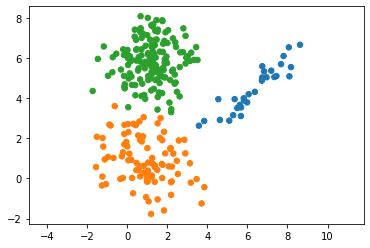

In [11]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(axis=1)
colors = np.array([(31, 119, 180), (255, 127, 14), (44, 160, 44)]) / 255.
plt.scatter(X[:, 0], X[:, 1], c=colors[labels], s=30)
plt.axis('equal')
plt.show()